# Does team salary in baseball correlate with winning?

Out of all the major sports in North America, baseball is the only sport that does not have a limit placed on how much each team can spend on players per year (salary cap). Because of this, I am curious to see if sucess can be bought in baseball. Fans (like me) from small market teams often have the preconveived notion that the teams who win are the ones who spend. I want to determine empirically if this is true or if it is a misconception.

I am using the Lahman's baseball database for all my analyses. This comprehensive database contains data on hitting, pitching, and fielding for teams and individual players from 1871 to 2016. To answer my question, I will need data on salaries and team wins. The two csv files that contain data pertinent to me are teams.csv and salary.csv.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import random
%matplotlib inline

In [2]:
#import datasets
df_teams = pd.read_csv("/Users/patrickgonzales/JupyterNotebook/baseballdatabank-2017.1/core/Teams.csv")
df_salaries = pd.read_csv("/Users/patrickgonzales/JupyterNotebook/baseballdatabank-2017.1/core/Salaries.csv")

## Let's take a look at the two datasets to determine if I need to make modifications to them.

In [3]:
team_sneakpeek = df_teams.head()
print(team_sneakpeek)

print('\n')

team_described = df_teams.describe()
print(team_described)

   yearID lgID teamID franchID divID  Rank   G  Ghome   W   L     ...       \
0    1871  NaN    BS1      BNA   NaN     3  31    NaN  20  10     ...        
1    1871  NaN    CH1      CNA   NaN     2  28    NaN  19   9     ...        
2    1871  NaN    CL1      CFC   NaN     8  29    NaN  10  19     ...        
3    1871  NaN    FW1      KEK   NaN     7  19    NaN   7  12     ...        
4    1871  NaN    NY2      NNA   NaN     5  33    NaN  16  17     ...        

   DP     FP                     name                          park  \
0 NaN  0.838     Boston Red Stockings           South End Grounds I   
1 NaN  0.829  Chicago White Stockings       Union Base-Ball Grounds   
2 NaN  0.814   Cleveland Forest Citys  National Association Grounds   
3 NaN  0.803     Fort Wayne Kekiongas                Hamilton Field   
4 NaN  0.839         New York Mutuals      Union Grounds (Brooklyn)   

   attendance  BPF  PPF  teamIDBR  teamIDlahman45  teamIDretro  
0         NaN  103   98       BOS      

In [4]:
salary_sneakpeek = df_salaries.head()
print(salary_sneakpeek)

print('\n')

salary_described = df_salaries.describe()
print(salary_described)

   yearID teamID lgID   playerID  salary
0    1985    ATL   NL  barkele01  870000
1    1985    ATL   NL  bedrost01  550000
2    1985    ATL   NL  benedbr01  545000
3    1985    ATL   NL   campri01  633333
4    1985    ATL   NL  ceronri01  625000


             yearID        salary
count  26428.000000  2.642800e+04
mean    2000.878727  2.085634e+06
std        8.909314  3.455348e+06
min     1985.000000  0.000000e+00
25%     1994.000000  2.947020e+05
50%     2001.000000  5.500000e+05
75%     2009.000000  2.350000e+06
max     2016.000000  3.300000e+07


There are issues with the data I need to address before beginning the analysis. First, there are differences in the number of games played, which will confound year to year comparisons. To normalize the data from year to year, I will need to add a winning percentage column. Also, the salary file contains information on salaries from 1985 to 2016. I will make a new team dataframe which corresponds to the years present in the salary file. Lastly, the salary dataset contains players salary by year. Since I am looking for team salaries- I will sum the players salaries after aggregating by team and year.

In [5]:
#new teams df and add win percentage column.
df_teams_subset = df_teams[df_teams['yearID'] >= 1985]
df_teams_subset['winPct'] = df_teams_subset['W'] / (df_teams_subset['L'] + df_teams_subset['W'])

#sum salaries by team for each year
df_team_salaries = df_salaries.groupby(['yearID', 'teamID']).sum().reset_index()

#merge salary and team subsets
df_merged = pd.merge(df_teams_subset, df_team_salaries, on=['yearID', 'teamID'])

/Users/patrickgonzales/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## The two variables crucial to my analysis are win percentage and salary. Do both variables follow a normal distribution?

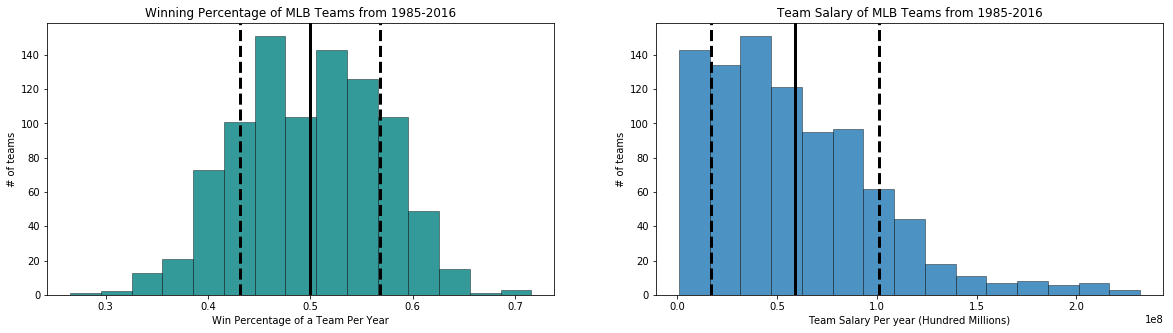

In [6]:
#plot histograms with mean and standard deviation lines for both variables.
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.hist(df_merged['winPct'], bins=15, edgecolor='black',linewidth=0.5, color='teal', alpha=0.8)
plt.axvline(df_merged['winPct'].mean(), color='black', linestyle='solid', linewidth=3)
plt.axvline(df_merged['winPct'].mean() + df_merged['winPct'].std(), color='black', linestyle='dashed', linewidth=3)
plt.axvline(df_merged['winPct'].mean() - df_merged['winPct'].std(), color='black', linestyle='dashed', linewidth=3)
plt.ylabel('# of teams')
plt.xlabel('Win Percentage of a Team Per Year')
plt.title('Winning Percentage of MLB Teams from 1985-2016')

plt.subplot(1, 2, 2)
plt.hist(df_merged['salary'], bins=15,  edgecolor='black', linewidth=0.5, alpha=0.8)
plt.axvline(df_merged['salary'].mean(), color='black', linestyle='solid', linewidth=3)
plt.axvline(df_merged['salary'].mean() + df_merged['salary'].std(), color='black', linestyle='dashed', linewidth=3)
plt.axvline(df_merged['salary'].mean() - df_merged['salary'].std(), color='black', linestyle='dashed', linewidth=3)
plt.ylabel('# of teams')
plt.xlabel('Team Salary Per year (Hundred Millions)')
plt.title('Team Salary of MLB Teams from 1985-2016')
plt.show()


The win percentage variable looks to be normally distributed, but the team salary is skewed towards the lower end of the salary scale. I believe this is a refelction of salary growth over time.

## Let's take a look at the average team salary over time to see if this explains the histogram above 

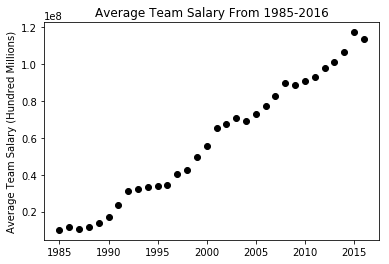

In [7]:
#create new df that contains the average salary of all teams by year
df_avg_salaries = df_merged.groupby(['yearID']).mean().reset_index()

#line graph to see how total average team salary has changed over time
plt.plot(df_avg_salaries['yearID'], df_avg_salaries['salary'],'o', color = 'black')
plt.ylabel('Average Team Salary (Hundred Millions)')
plt.title('Average Team Salary From 1985-2016')
plt.show()

The average team salary changes from year to year, but not at a linear rate and doesn't even always increase. Because of the varied rate of change in average-team-salaries over the years, I am not going to get a normal distribution for team salary when aggregating the data. 

##   Is the team salary normally distributed if I look by year?

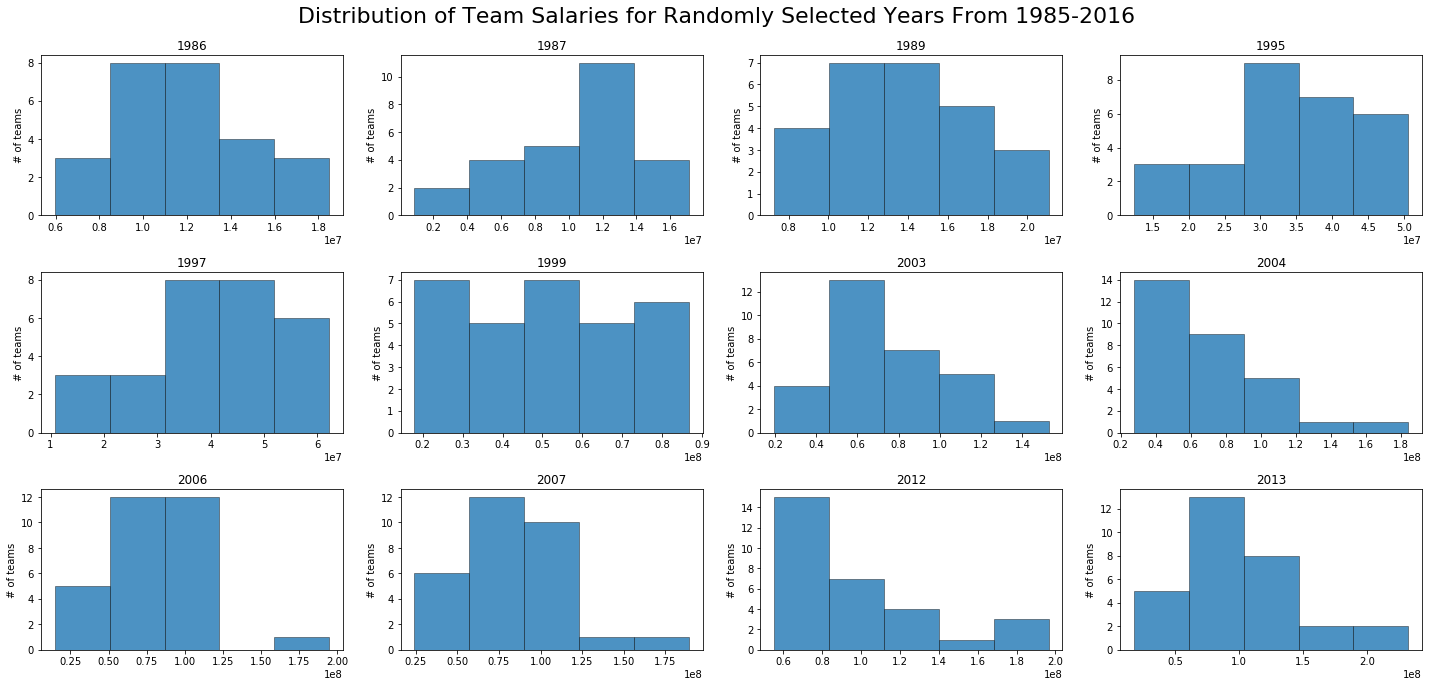

In [8]:
#randomly select 12 years from 1985-2016 and check if yearly salary distributions are normal with histogram.
years = list(range(1985, 2017))
randYears = random.sample(years, 12)
randYears.sort()

temp_df = pd.DataFrame()
plotNum = 1
plt.figure(figsize=(20, 10))

for year in randYears:
    temp_df = df_merged[df_merged['yearID'] == year]
    plt.subplot(3, 4, plotNum)
    plt.hist(temp_df['salary'], bins=5,  edgecolor='black', linewidth=0.5, alpha=0.8)
    plt.title(year)
    plt.ylabel('# of teams')
    #plt.xlabel('Salary')
    plotNum += 1

plt.suptitle('Distribution of Team Salaries for Randomly Selected Years From 1985-2016', size=22)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()     

I was expecting normality here. However, this is not uniformly the case. I believe it is safe to say that team salary is not normaly distributed.

#### If I am going to answer my question and determine if there is a correlation between wins and salary, then I will need to normalize the data. To do so, I will create a column that ranks the team salaries for each year and another column that ranks the team win percentage by year. I then can make a scatterplot of win percentage ranking vs. salary ranking to see if there is a correlation between the two variables.

In [9]:
#use pandas df.rank to rank from highest(1) to lowest(30) for salary and win percentage
df_merged['winPctRank'] = df_merged.groupby(['yearID'])['winPct'].rank(ascending=False)
df_merged['SalaryRank'] = df_merged.groupby(['yearID'])['salary'].rank(ascending=False)

## Is there a correlation between salary and win percentage?

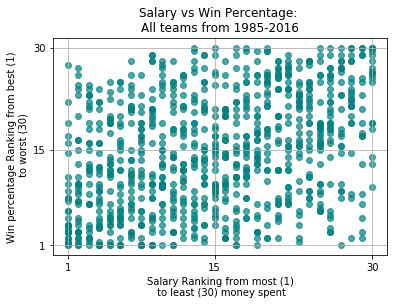

SpearmanrResult(correlation=0.36901367014935876, pvalue=1.2218481965340829e-30)

In [10]:
plt.scatter(df_merged['SalaryRank'], df_merged['winPctRank'], color='teal', alpha='0.7', label='All Teams')
plt.ylabel('Win percentage Ranking from best (1)\n to worst (30)')
plt.xlabel('Salary Ranking from most (1)\n to least (30) money spent')
plt.title('Salary vs Win Percentage: \nAll teams from 1985-2016')
ax = plt.gca()
plt.grid()
ax.set_yticks([1,15,30])
ax.set_xticks([1,15,30])
plt.show()

stats.spearmanr(df_merged['SalaryRank'], df_merged['winPctRank'])

There is definitely not a 1 to 1 correlation between salary and win percentage. However, there is a significant weak positive correlation according to the spearmans rank test. From the graph it is apparent that there are examples of teams spending big and losing more often than not, spending small and winning more, and every variation in between.

#### Ok. So spending more money doesn't guarantee you more wins. Maybe I should look at this another way. Ultimately, the team goal is to win the world series. To do that you need to at least make the post-season. Let's rephrase the question.


## Does a higher team salary increase your chance to make the playoffs? What about winning the world series?

#### To address my new question, I am going bin the salaries into quartiles  and see if the percentage of non-playoff teams, playoff teams, and world series winners who fall into the four quartiles are equal. Salaries in Q1 are the smallest and Q4 largest.

In [11]:
#find salary quartiles 
Q1 = df_merged['salary'].quantile(0.25)
Q2 = df_merged['salary'].quantile(0.50)
Q3 = df_merged['salary'].quantile(0.75)

#function quant_count
def quant_count(column):
    total = len(column)
    quant_dict = {'Q1': 0, 'Q2': 0, 'Q3': 0, 'Q4': 0}
    quant_dict['Q1'] = round((sum(1 for i in column if i < Q1)) / total, 2)
    quant_dict['Q2'] = round((sum(1 for i in column if i > Q1 and i < Q2)) / total, 2)
    quant_dict['Q3'] = round((sum(1 for i in column if i > Q2 and i < Q3)) / total, 2)
    quant_dict['Q4'] = round((sum(1 for i in column if i > Q3)) / total, 2)
    return quant_dict

#make new data frames containing division winners, world series winners, and everybody else.
df_Divwin = df_merged[df_merged['DivWin'] == 'Y']
df_WSwin = df_merged[df_merged['WSWin'] == 'Y']
df_noPlayoff = df_merged[df_merged['WSWin'] == 'N']
df_noPlayoff = df_merged[df_merged['DivWin'] == 'N']

In [12]:
#use quantile function on dataframes
print('Salary quartiles for teams not going to playoffs')
quant_count(df_noPlayoff['salary'])

print('\nSalary quartiles for teams going to playoffs')
quant_count(df_Divwin['salary'])

print('\nSalary quartiles for teams who won world series')
quant_count(df_WSwin['salary'])

Salary quartiles for teams not going to playoffs

Salary quartiles for teams going to playoffs

Salary quartiles for teams who won world series


{'Q1': 0.23, 'Q2': 0.17, 'Q3': 0.13, 'Q4': 0.47}

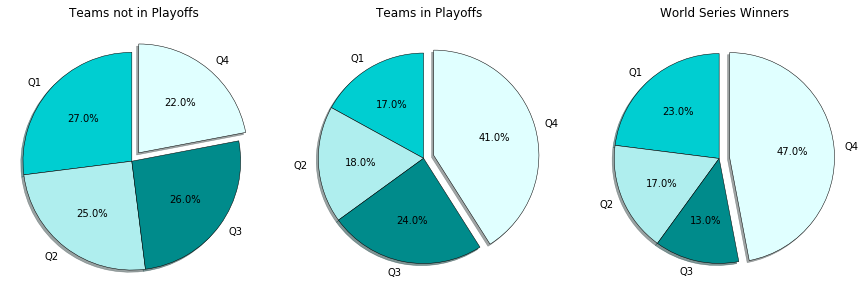

In [13]:
plt.figure(figsize=(15, 5))

#no playoffs
plt.subplot(1, 3, 1)
plt.pie([0.27, 0.25, 0.26, 0.22],
        labels=['Q1', 'Q2', 'Q3', 'Q4'],
        colors=['darkturquoise', 'paleturquoise', 'darkcyan', 'lightcyan'],
        autopct='%1.1f%%', shadow=True, startangle=90, explode = (0, 0, 0, 0.1),
        wedgeprops ={"edgecolor":"k",'linewidth': 0.5, 'linestyle': 'solid', 'antialiased': True})
plt.title('Teams not in Playoffs') 
plt.axis('equal')

#playoffs
plt.subplot(1, 3, 2)
plt.pie([0.17, 0.18, 0.24, 0.41],
        labels=['Q1', 'Q2', 'Q3', 'Q4'],
        colors=['darkturquoise', 'paleturquoise', 'darkcyan', 'lightcyan'],
        autopct='%1.1f%%', shadow=True, startangle=90, explode = (0, 0, 0, 0.1),
        wedgeprops ={"edgecolor":"k",'linewidth': 0.5, 'linestyle': 'solid', 'antialiased': True})
plt.title('Teams in Playoffs') 
plt.axis('equal')

#world series
plt.subplot(1, 3, 3)
plt.pie([0.23, 0.17, 0.13, 0.47],
        labels=['Q1', 'Q2', 'Q3', 'Q4'],
        colors=['darkturquoise', 'paleturquoise', 'darkcyan', 'lightcyan'],
        autopct='%1.1f%%', shadow=True, startangle=90, explode = (0, 0, 0, 0.1),
        wedgeprops ={"edgecolor":"k",'linewidth': 0.5, 'linestyle': 'solid', 'antialiased': True})
plt.title('World Series Winners') 
plt.axis('equal')
plt.show()

This set of pie charts illustrate the following:
1. Teams from every pay scale are almost equally vulnerable to miss out on the playoffs .
2. However, if you want to make the playoffs, your best bet is to have a salary in the top quartile. Teams in the top quartile make the playoffs 2.4 times more often than teams in the bottom quartile. 
3. Almost half of all world series winners also come from the big salary teams. But surprisingly, 23% of world series winners are from the bottom salary teams- which is enough to give fanbases of these teams hope.

#### The pie charts are interesting and informative...but I need to know if I am correct generalizing the results. For instance, what if the phenomenon we see above is true for the past five years, but not for the first 10 years the salary data was being collected. I think there's one more thing I want to look at. 

## How do the salaries from non-playoff teams, playoff teams, and world series winning teams look over time?

/Users/patrickgonzales/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


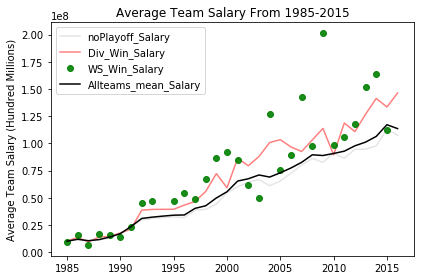

In [14]:
#rename salary column for clarity in key
df_Divwin.rename(columns = {'salary':'Div_Win_Salary'}, inplace = True)
df_WSwin.rename(columns = {'salary':'WS_Win_Salary'}, inplace = True)
df_noPlayoff.rename(columns = {'salary':'noPlayoff_Salary'}, inplace = True)
df_avg_salaries.rename(columns = {'salary':'Allteams_mean_Salary'}, inplace = True)

#get average salary by year for each and plot on line graph
df_noPlayoff_avg = df_noPlayoff.groupby(['yearID']).mean().reset_index()
df_Divwin_avg = df_Divwin.groupby(['yearID']).mean().reset_index()

#plot averaqe salary by year on line plot
plt.plot(df_noPlayoff_avg['yearID'], df_noPlayoff_avg['noPlayoff_Salary'],'-', color = 'black', alpha=0.1)
plt.plot(df_Divwin_avg['yearID'], df_Divwin_avg['Div_Win_Salary'],'-', color = 'red', alpha=0.5)
plt.plot(df_WSwin['yearID'], df_WSwin['WS_Win_Salary'],'o', color = 'green', alpha=0.9)
plt.plot(df_avg_salaries['yearID'], df_avg_salaries['Allteams_mean_Salary'],'-', color = 'black')
plt.ylabel('Average Team Salary (Hundred Millions)')
plt.title('Average Team Salary From 1985-2015')
plt.legend(loc='upper left')
plt.tight_layout(w_pad=3)
plt.show()


This plot confirms the assertion that teams who made the playoffs have a salary above the mean and a salary higher than non-playoff teams. Particularly after 1991. If I sliced the data from 1991 on, the data supporting the assertion would be even stronger. As far as world series goes for the low spending teams...this figure paints a much bleaker picture than the pie chart. Only 3 teams since 1991 have won the world series with a salary lower than the mean salary. 

Note: there is a missing point in 1994. There was a strike that year and no world series was played. 

## Conclusion

There is a perception in baseball that teams who can pay more win more. As a fan of a small market baseball team (Rockies) I've often said, "were going to need to open our checkbooks to compete with the big market teams like the Dodgers or Yankees". After finishing this analysis I am both hopeful and discouraged. 

I am hopeful because there is not a clear one to one relationship between increased salary and increased win percentage. There are many examples of teams who were in the lower salary bracket yet had winning percentages near the top of the league. These low salary success stories also extend to the playoffs and even the world series. So there's a chance! 

Yes there's a chance, but not as good of a chance as the teams who spend money. In fact, if you look at playoff teams and the lions share of world series winners, greater than ~40% of the teams are in the upper salary bracket. To make matters worse, only 13% of the teams below the average league salary have won the world series since 1991. 

## Further Research

#### There are a few questions this analysis has raised that deserve follow up. 

What seperates teams that spend big and win from teams that spend big and lose? Can we quantify it? We could look at the distribution of salaries...do the winning teams spread the wealth around or is the bulk of their salary tied up in a few great players? Do winning teams value (pay) pitchers more or power hitters? 

What about small-market low salary teams who win versus ones that lose? We can look at the same questions posited above to see if there is a way to extract the most out of a smaller budget.

This pertains to the last line plot of my analysis. What salary rules were in place from 1985-1991? It seems to me that the health of a sport is at its optimum when there is parity ( this statement could be analyzed too). It may behoove the MLB to look at that time frame and see if revenue or tv ratings were higher. If so, you could implement rules to create more parity. For example,  a salary cap.